In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
from scipy.linalg import solve_continuous_lyapunov
np.set_printoptions(precision=5, suppress=True)
import time
from utils import * 
from inference import *

In [280]:
def convert_params(params): 
    ''' 
    lambda, gamma, mu, c, b, sigma_d, sigma_p 
    '''
    c = params[3]/params[0]
    gamma = params[1] + c*params[2] 
    J = np.array([[-params[0], params[2]], [-params[3], -params[1]]])
    if gamma < 0: 
        sigma_p = 1e-10 
    else: 
        sigma_p = np.sqrt(gamma)
    B = np.diagflat([params[-1]**2, sigma_p**2])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

In [300]:
class nonlinear_model(sim): 
    
    def __init__(self, params, convert_params):
        super().__init__(params, convert_params) 
        self.b = params[4]

    def _update(self, y, dt):
        det = self.J @ y 
        det[1] -= self.b* y[1]**3 
        sto = np.sqrt(dt) * self.rv.rvs()
        y += det*dt + sto 

In [301]:
class nonlinear_inference(inference):
                   
    def _minuslogP(self, params, trajs, dt):
        '''
        traj: 2 x T 
        '''
        J, B = self.convert_params(params)
        b = params[4]
        invB = np.linalg.inv(B*dt) 
        _, norm = np.linalg.slogdet(invB)

        minuslogp = 0 
        for traj in trajs: 
            N = traj.shape[-1] - 1
            dx = traj[:, 1:] - traj[:, :-1]
            det = J @ traj[:, :-1]
            det[1] -= b*traj[1, :-1]**3 
            diff = dx - det*dt 
    
            minuslogp += np.einsum('ji,jk,ki', diff, invB, diff)/2 
            minuslogp -= N*norm/2
        return minuslogp

### First, we make some simulations with known parameters and infer them with both inference methods

In [304]:
# params in order of [epsilon, gamma-mu*c, mu, c]
dt = 5e-3
n_frames = 100
T = 3.3e-2*n_frames
n_repeats = 1

#  epsilon, gamma, mu, ce, b, sigma_d, sigma_p  
gamma = 1
c = 78/(4/gamma)
mu = 0.1
epsilon = 0.18 
params = [epsilon, gamma-c*mu , mu, c*epsilon, 88/(4/gamma), 0.03]

J, B = convert_params(params)
print(J)
print(B)
print(np.linalg.eigvals(J))

m = nonlinear_model(params, convert_params)
results = m.evolve(T, dt, int(n_frames), n_repeats)

[[-0.18  0.1 ]
 [-3.51  0.95]]
[[0.0009  0.01755]
 [0.01755 1.34223]]
[0.385+0.17826j 0.385-0.17826j]


TypeError: 'Axes' object is not subscriptable

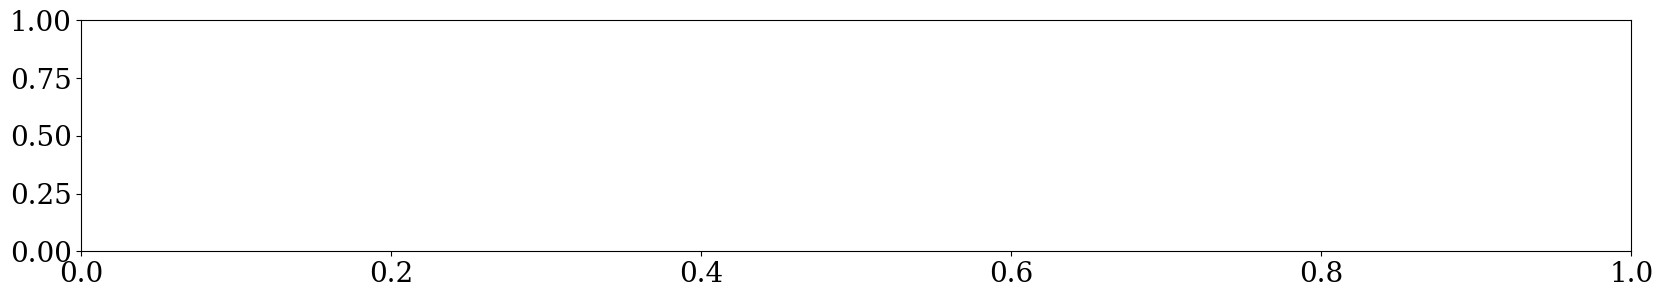

In [303]:
show(results)
plot_overall_dist(results)

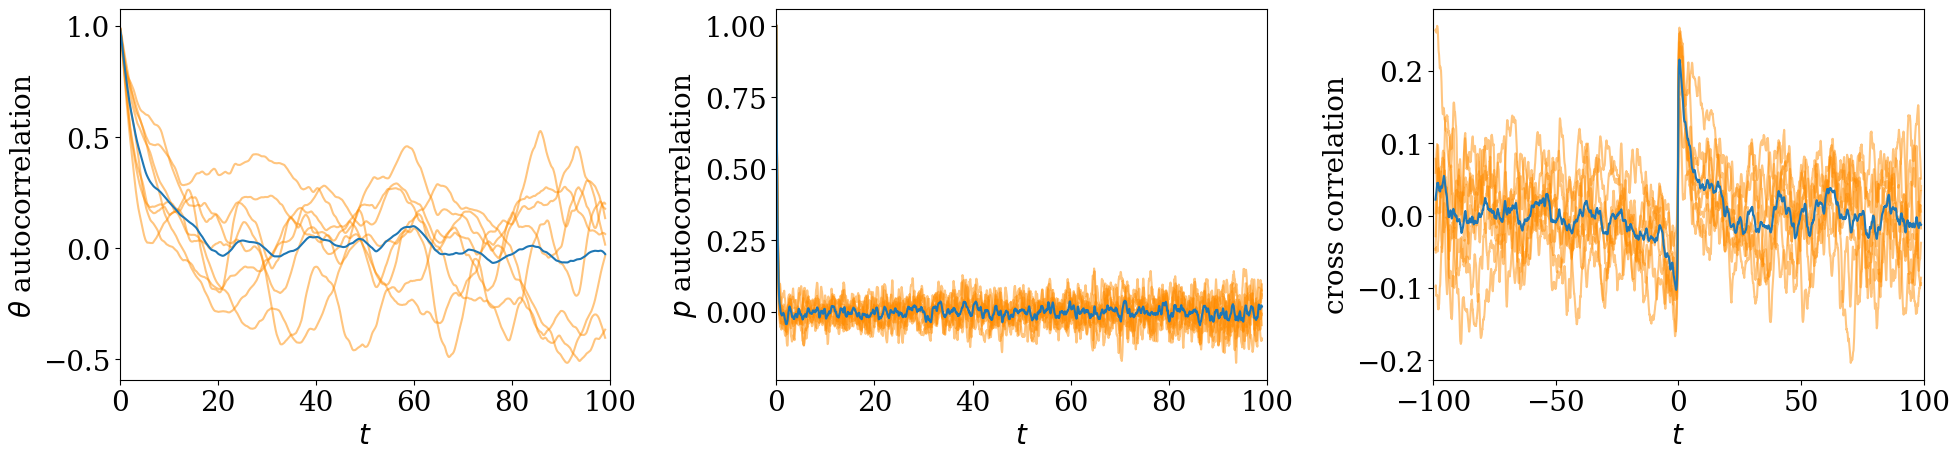

In [263]:
plot_corr(results, 3000, 3.3e-2, norm=True); 

In [305]:
inf = nonlinear_inference(convert_params)

t1 = time.time() 
minuslogp = inf._minuslogP(params, results, T/n_frames)
t2 = time.time() 
print('time taken: ', t2-t1)
print(minuslogp)

time taken:  0.00011181831359863281
-620.6311543245569


In [221]:
## Numerical inference
inf = nonlinear_inference(convert_params)
guess = [1, 1, 1, 1, 100, 0.1]
bounds = [[1e-6, None]]*6
MAP, cost = inf.inf(guess, results, (T/n_frames), bounds=bounds)
print(MAP, cost)
print('true params:', params, inf._minuslogP(params, results, T/n_frames))

[ 0.16679  0.75174  0.08575  3.06941 16.60482  0.02919] -243534.82007095902
true params: [0.18, 1, 0.1, 3.51, 22.0, 0.03] -242405.30613503038


In [65]:
delta = 1e-4*MAP 
delta[0] = 1e-3
ste, _ = inf.std_error(MAP, results, T/n_frames, delta=delta)
print(ste)

[    nan 0.02305 0.00319     nan 0.28064 0.00014]


/Users/yuli/Documents/Code/ActivePoly/inference.py:70: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diagonal(np.linalg.inv(hess))), hess


In [222]:
path = 'Data/N11_ThetaPola_DATA/'
files = [f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(path+f)['POLA'])
    else: 
        theta_trajs.append(loadmat(path+f)['THETAd'])

N11_1_R200_B30_04_05_POLARIZATION.mat N11_1_R200_B30_04_05_ThetaTime.mat
N11_1_R200_B50_04_05_POLARIZATION.mat N11_1_R200_B50_04_05_ThetaTime.mat
N11_1_R200_B50_25_04_POLARIZATION.mat N11_1_R200_B50_25_04_ThetaTime.mat
N11_1_R200_B50_26_04_POLARIZATION.mat N11_1_R200_B50_26_04_ThetaTime.mat
N11_2_R200_B50_26_04_POLARIZATION.mat N11_2_R200_B50_26_04_ThetaTime.mat
N11_3_R200_B50_25_04_POLARIZATION.mat N11_3_R200_B50_25_04_ThetaTime.mat
N11_4_R200_B100_25_04_POLARIZATION.mat N11_4_R200_B100_25_04_ThetaTime.mat
N11_4_R200_B30_25_04_POLARIZATION.mat N11_4_R200_B30_25_04_ThetaTime.mat
N11_4_R200_B50_25_04_POLARIZATION.mat N11_4_R200_B50_25_04_ThetaTime.mat
N11_5_R200_B30_25_04_POLARIZATION.mat N11_5_R200_B30_25_04_ThetaTime.mat
N11_5_R200_B50_25_04_POLARIZATION.mat N11_5_R200_B50_25_04_ThetaTime.mat


In [223]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))
theta_trajs.pop(2);
pol_trajs.pop(2); 
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))

[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]


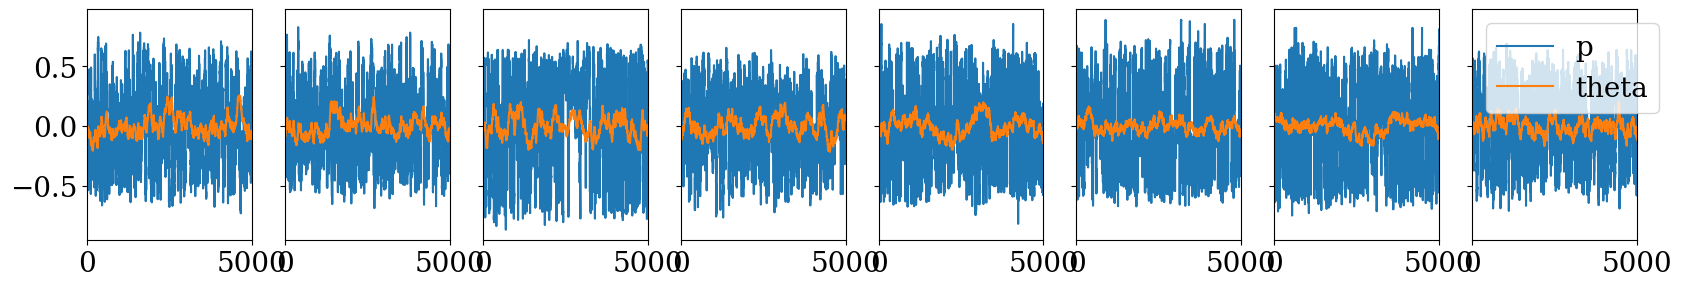

In [252]:
f1 = lambda x: (x[:, 1])/180*np.pi - np.mean(x[:, 1])/180*np.pi
f2 = lambda x: np.mean(x[:, 1:4], axis=1) - np.mean(x[:, 1:4])
f3 = lambda x: np.sin(x[:, 2]) - np.mean(np.sin(x[:, 2]))
data = [np.stack([f1(theta), f3(p)]) for (theta, p) in zip(theta_trajs, pol_trajs)]
dt = 0.03333333333333333
show([d for d in data if len(d[0]) == 5000])

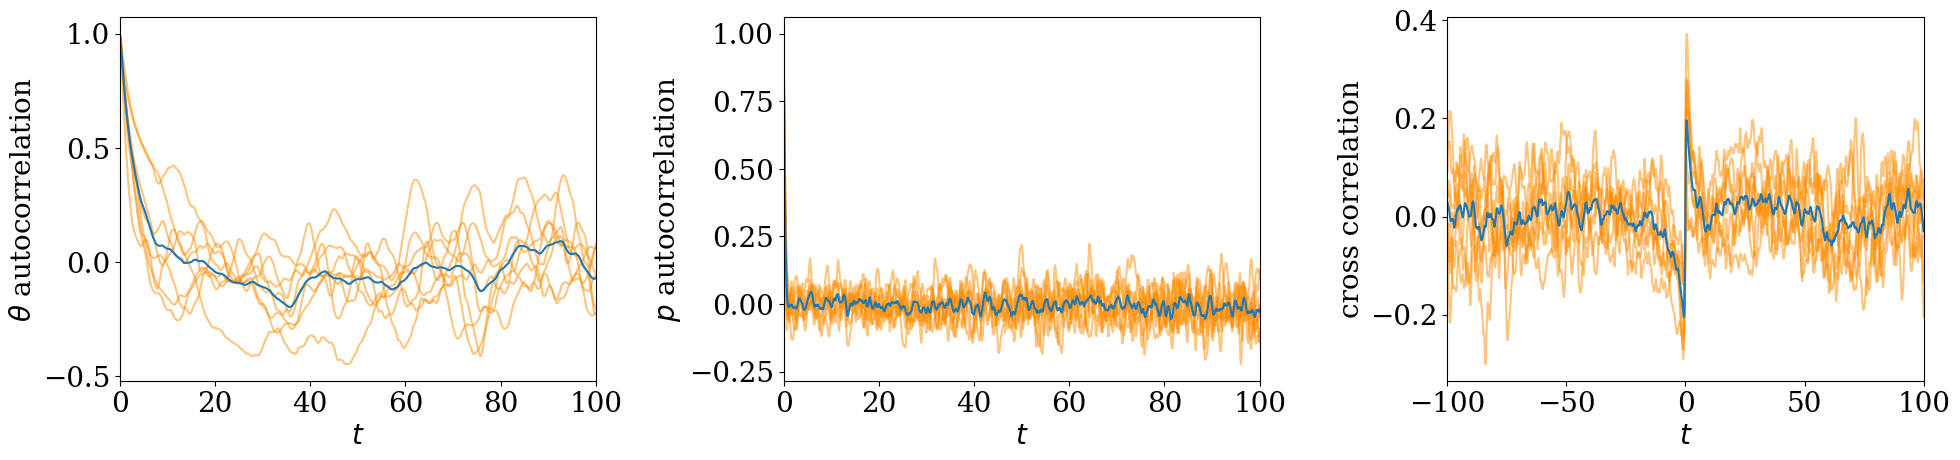

In [253]:
plot_corr([d for d in data if len(d[0]) == 5000], 3000, dt); 

In [291]:
guess = params
bounds = [[0, None]]*6
bounds[1] = [None, None]

inf = nonlinear_inference(convert_params)
MAP, y = inf.inf(guess, data, dt, bounds=bounds)
J, B = convert_params(MAP)
print(MAP, y, B)
print(params, inf._minuslogP(params, data, dt))

[ 0.10177 -0.40278  0.17607  0.52614 10.68311  0.02553] -283883.7882411454 [[0.00065 0.00337]
 [0.00337 0.52489]]
[0.18, -0.9500000000000002, 0.1, 3.51, 22.0, 0.03] -274979.27954346774


In [292]:
delta = MAP*1e-4
delta[0]= 1e-3
std_err, hess = inf.std_error(MAP, data, dt, delta)
print('fractional error:', std_err/MAP)
print('absolute error:', std_err)
print(np.linalg.eigvals(hess)) # check that all eigenvalues of the Hessian are positive 

fractional error: [     nan -0.0482   0.01098  0.0212   0.02085  0.00336]
absolute error: [    nan 0.01941 0.00193 0.01115 0.22279 0.00009]
[ 1.35875e+08  9.67776e+06  2.07410e+05 -5.42083e+03  1.62735e+03
  2.01215e+01]


In [293]:
guess = MAP

n_frames = 5000
dt = 0.03333333333333333 
m = nonlinear_model(guess, convert_params)
print(m.J, m.b)
print(np.linalg.eigvals(J))
n_repeats = 4
sims = m.evolve(n_frames*dt, 3.3e-3, n_frames, n_repeats)

[[-0.10177  0.17607]
 [-0.52614  0.40278]] 10.68310858642476
[0.1505+0.17028j 0.1505-0.17028j]


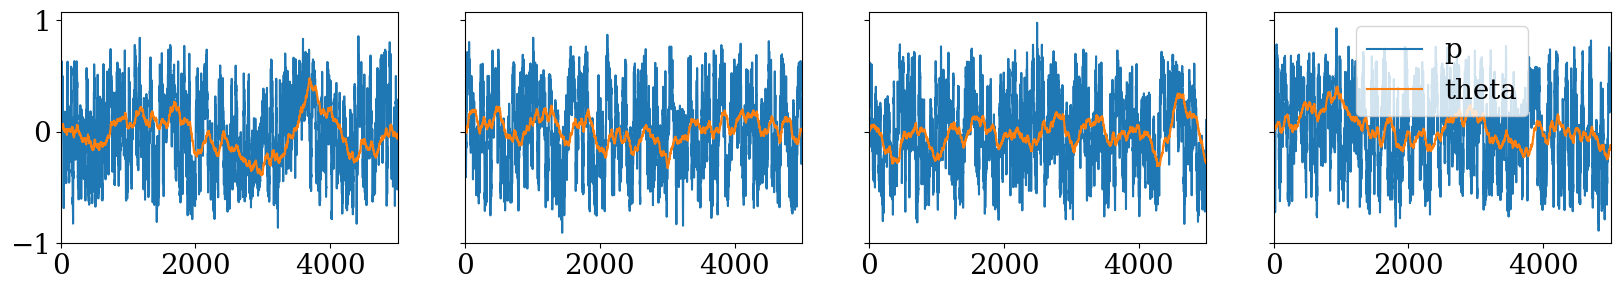

In [294]:
show(sims)

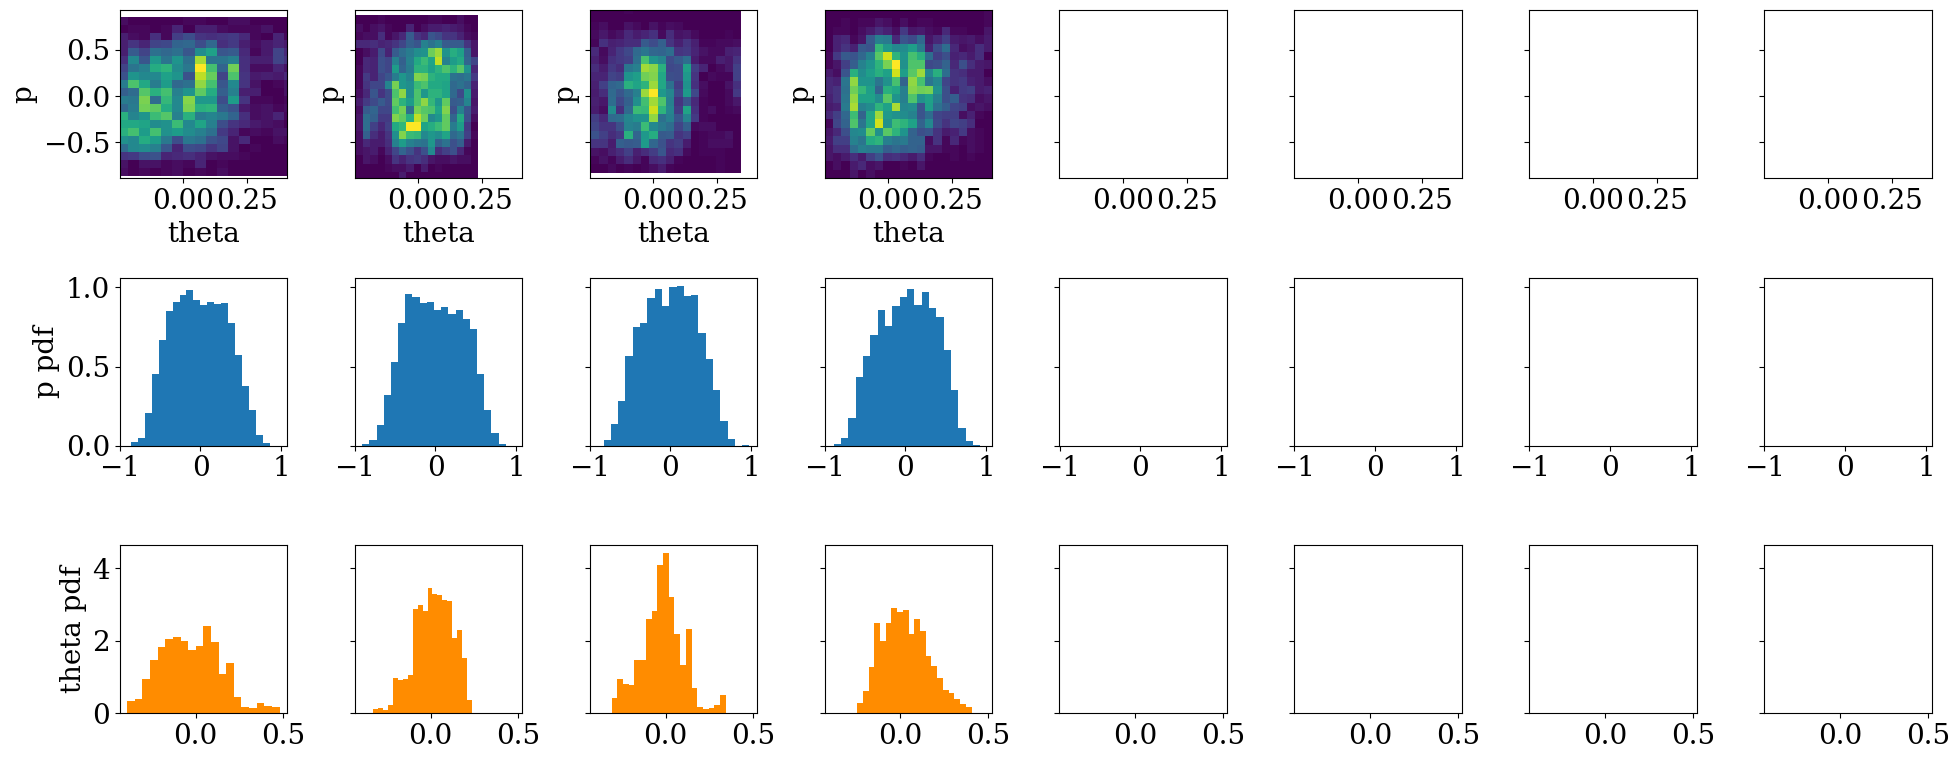

In [295]:
plot_dist(sims)

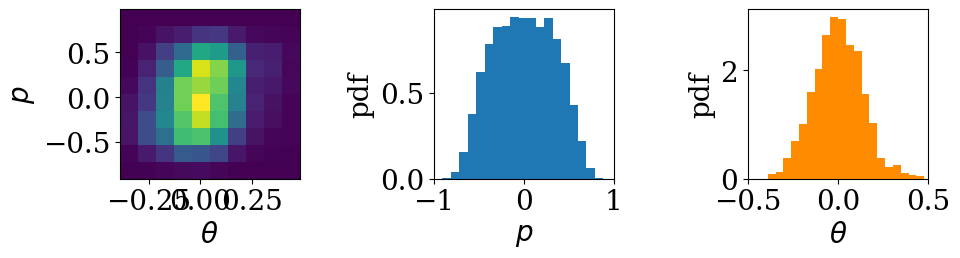

In [296]:
plot_overall_dist(sims)

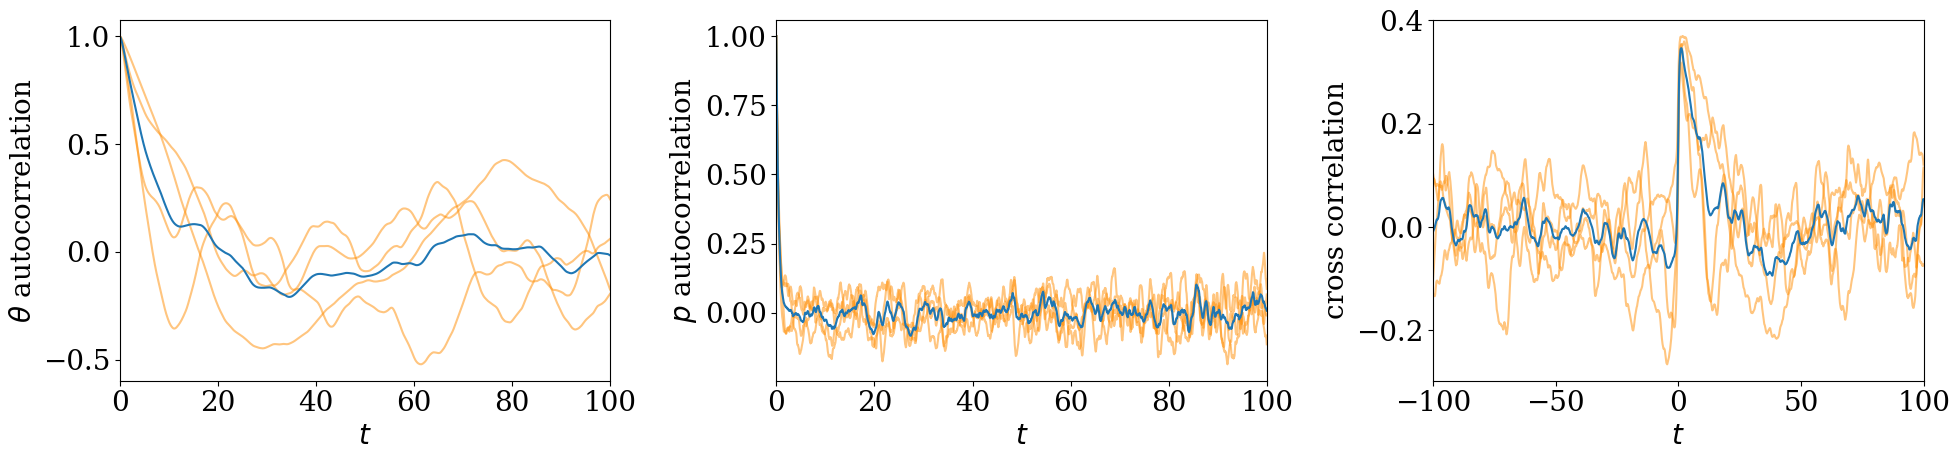

In [297]:
plot_corr(sims, 3000, dt); 

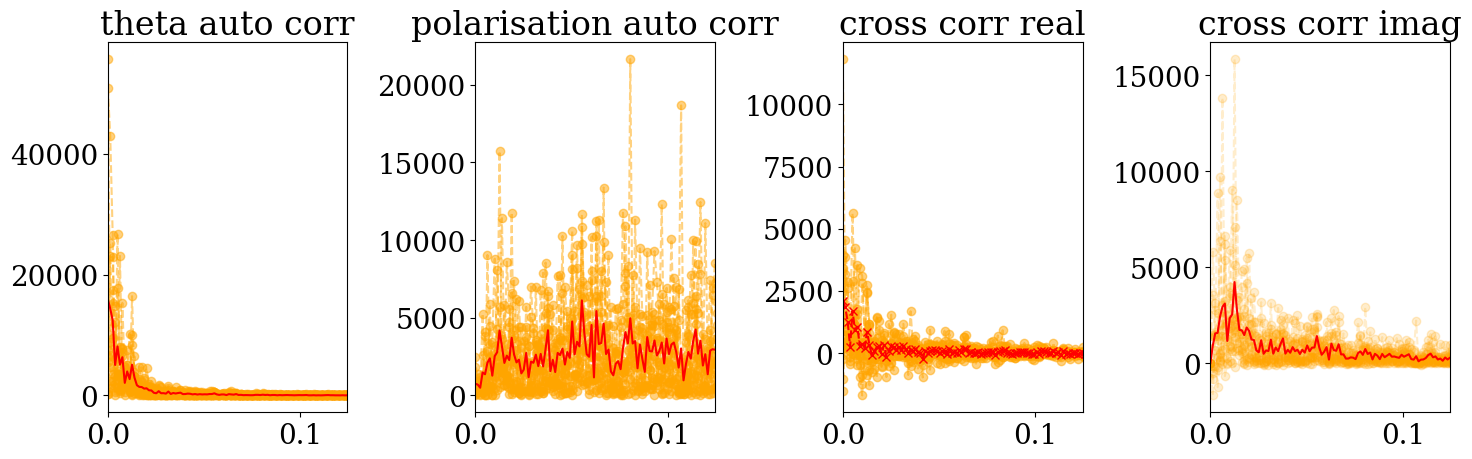

(array([15895.35469, 14374.91893, 12417.30963, ...,     0.02579,
            0.02502,     0.03782]),
 array([749.45553, 697.52054, 496.51036, ...,  77.63107, 133.25384,
        102.1555 ]),
 array([2097.24723   +0.j     , 1845.13366 +903.69046j,
        1261.15659+1545.14178j, ...,    0.19919   +0.11233j,
           1.01217   +0.00889j,    1.12129   +0.j     ]))

In [179]:
plot_corr_ft(np.array(sims), dt)